In [1]:
import pandas as pd
import numpy as np
import json
import os

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.metrics import ndcg_score
from tqdm import tqdm

sns.set(rc={'figure.figsize':(19, 11)}, font_scale=2)

# Functions

In [2]:
def get_entities_per_table_dict(path):
    '''
    Given the path to a tableIDToEntities.ttl file return a dictionary mapping each tableID to a list of its entities
    '''
    entities_per_table_dict = {}

    with open(path) as file:
        for line in tqdm(file):
            vals = line.rstrip().split()
            tableID = vals[0].split('/')[-1][:-1] + '.json'
            entity = vals[2][1:-1]
                        
            if tableID not in entities_per_table_dict:
                entities_per_table_dict[tableID] = [entity]
            else:
                entities_per_table_dict[tableID].append(entity)

    return entities_per_table_dict

def create_query_file(dir, filename, query_entity_tuples):
    '''
    Create the query json file with name `filename` and save it in the specified `dir`

    `query_entity_tuples`: is a 2D of query entities. A list of entities for each query tuple
    '''
    query_dict = {"queries": []}

    for query_ents_per_tuple in query_entity_tuples:
        query_dict['queries'].append(query_ents_per_tuple)
    
    with open(dir + filename + '.json', 'w') as fp:
        json.dump(query_dict, fp, indent=4)

# Identify Wikipages mutliple tables that map to multiple entities

In [3]:
# Minimum number of entities per table to be considered
num_entities_threshold=10

In [4]:
with open('wikipage_tables.json', 'r') as fp:
    wikipage_tables_dict = json.load(fp)

df_dict = {'wikipage': [], 'wikipage_id': [], 'num_tables': [], 'tables': [], 'num_entities': []}
wikipage_id = 0
for wikipage, wikipage_dict in wikipage_tables_dict.items():
    
    df_dict['wikipage'].append(wikipage)
    df_dict['wikipage_id'].append(wikipage_id)
    wikipage_id+=1
    wikipage_tables = []
    num_entities = []

    # For the current 'wikipage' identify how many tables there are with entities greater or equal to 'num_entities_threshold'
    for tableID in wikipage_dict['tables']:
        num_ents = wikipage_dict['tables'][tableID]['num_entities']
        
        if num_ents >= num_entities_threshold:
            wikipage_tables.append(tableID)
            num_entities.append(num_ents)

    df_dict['tables'].append(wikipage_tables)
    df_dict['num_tables'].append(len(wikipage_tables))
    df_dict['num_entities'].append(num_entities)

df = pd.DataFrame.from_dict(df_dict)
df

,wikipage,wikipage_id,num_tables,tables,num_entities
0,https://en.wikipedia.org/wiki/Mid_Antrim_(Nort...,0,1,[table-0001-1.json],[13]
1,https://en.wikipedia.org/wiki/Paganini_Competi...,1,3,"[table-0001-101.json, table-0001-102.json, tab...","[32, 14, 32]"
2,https://en.wikipedia.org/wiki/List_of_musical_...,2,1,[table-0001-104.json],[182]
3,https://en.wikipedia.org/wiki/Richmond_Footbal...,3,2,"[table-0001-106.json, table-0001-109.json]","[16, 14]"
4,https://en.wikipedia.org/wiki/Red_Bull_BC_One,4,3,"[table-0001-112.json, table-0001-113.json, tab...","[16, 13, 17]"
...,...,...,...,...,...
244241,https://en.wikipedia.org/wiki/2005_Big_Ten_Con...,244241,1,[table-1653-93.json],[10]
244242,https://en.wikipedia.org/wiki/Collezione_dei_d...,244242,1,[table-1653-94.json],[45]
244243,https://en.wikipedia.org/wiki/New_Jersey_Route_29,244243,1,[table-1653-97.json],[12]
244244,https://en.wikipedia.org/wiki/2003_Big_Ten_Con...,244244,1,[table-1653-98.json],[10]


In [5]:
print("There are in total", len(df.index), 'wikipages.', len(df[df['num_tables']==0].index), 'wikipages removed because they have 0 wikitables with', num_entities_threshold, 'or more entities')

There are in total 244246 wikipages. 94703 wikipages removed because they have 0 wikitables with 10 or more entities


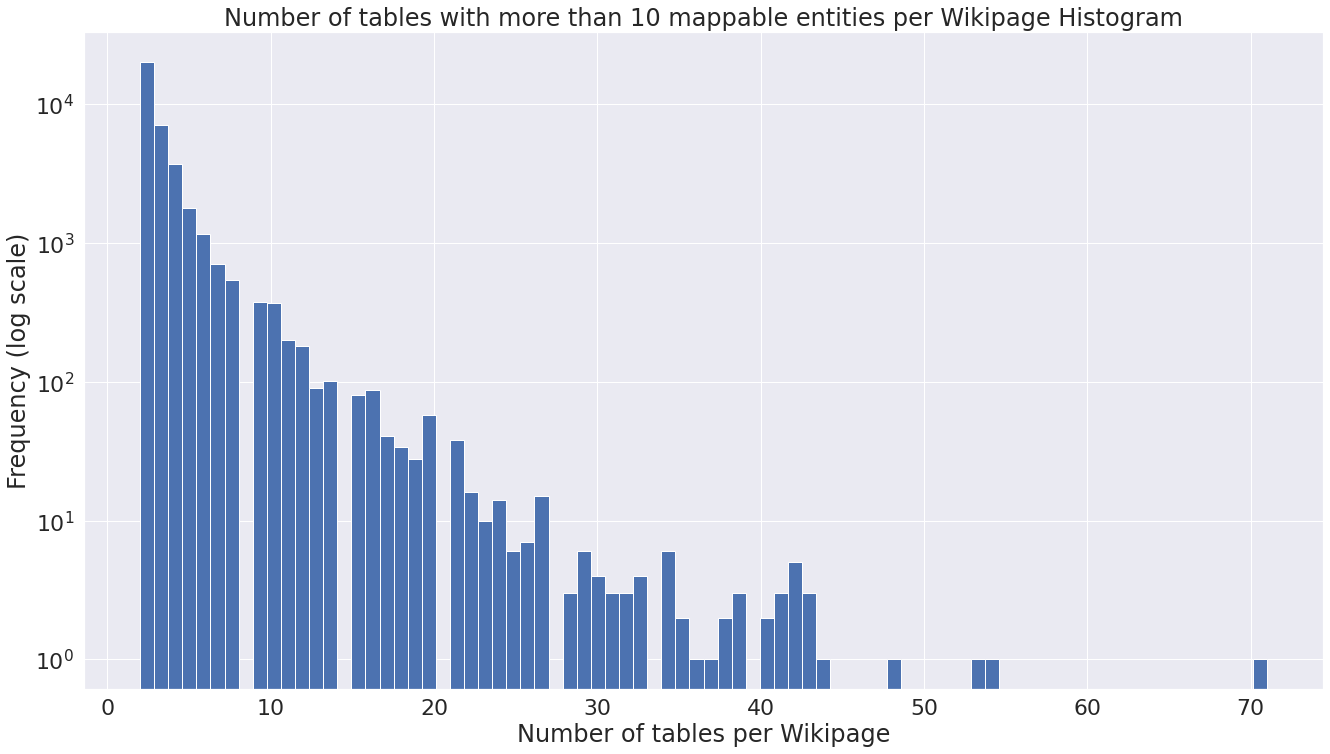

In [6]:
# Remove all wikipages with 1 histogram and remove the one wikipage with 4180 tables 
ax = plt.hist(df[(df['num_tables'] >= 2) & (df['num_tables'] <=200)]['num_tables'], bins=80)
plt.yscale('log');plt.xlabel("Number of tables per Wikipage")
plt.ylabel('Frequency (log scale)');plt.title('Number of tables with more than ' + str(num_entities_threshold) + ' mappable entities per Wikipage Histogram');plt.tight_layout()
plt.savefig('../figures/num_tables_per_wikipage_histogram.svg')

In [7]:
# Select wikipages from which we construct the queries
df_queries = df[(df['num_tables'] >= 20) & (df['num_tables'] <=40)]
df_queries

,wikipage,wikipage_id,num_tables,tables,num_entities
124,"https://en.wikipedia.org/wiki/List_of_Murder,_...",124,20,"[table-0001-805.json, table-0001-806.json, tab...","[50, 19, 52, 66, 124, 29, 12, 68, 59, 101, 130..."
5350,https://en.wikipedia.org/wiki/PFA_Team_of_the_...,5350,35,"[table-0035-275.json, table-0035-282.json, tab...","[11, 11, 10, 11, 10, 10, 11, 10, 10, 11, 10, 1..."
5768,https://en.wikipedia.org/wiki/List_of_birds_of...,5768,30,"[table-0038-596.json, table-0038-599.json, tab...","[19, 24, 40, 24, 14, 13, 36, 16, 29, 27, 18, 1..."
6361,https://en.wikipedia.org/wiki/List_of_Disney_a...,6361,27,"[table-0042-682.json, table-0042-683.json, tab...","[11, 10, 14, 16, 12, 14, 19, 14, 14, 11, 19, 2..."
6755,https://en.wikipedia.org/wiki/List_of_assassin...,6755,30,"[table-0045-486.json, table-0045-487.json, tab...","[20, 19, 39, 25, 18, 63, 12, 10, 13, 45, 14, 6..."
...,...,...,...,...,...
240699,https://en.wikipedia.org/wiki/List_of_Washingt...,240699,20,"[table-1631-670.json, table-1631-671.json, tab...","[67, 86, 148, 83, 88, 70, 166, 33, 26, 81, 88,..."
242068,https://en.wikipedia.org/wiki/Penn_State_Nitta...,242068,31,"[table-1640-761.json, table-1640-763.json, tab...","[17, 20, 19, 21, 14, 17, 16, 22, 19, 20, 18, 1..."
242072,https://en.wikipedia.org/wiki/Penn_State_Nitta...,242072,21,"[table-1640-820.json, table-1640-821.json, tab...","[18, 19, 25, 22, 25, 19, 20, 23, 19, 21, 20, 2..."
242252,https://en.wikipedia.org/wiki/List_of_Canada_G...,242252,24,"[table-1641-793.json, table-1641-794.json, tab...","[13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 1..."


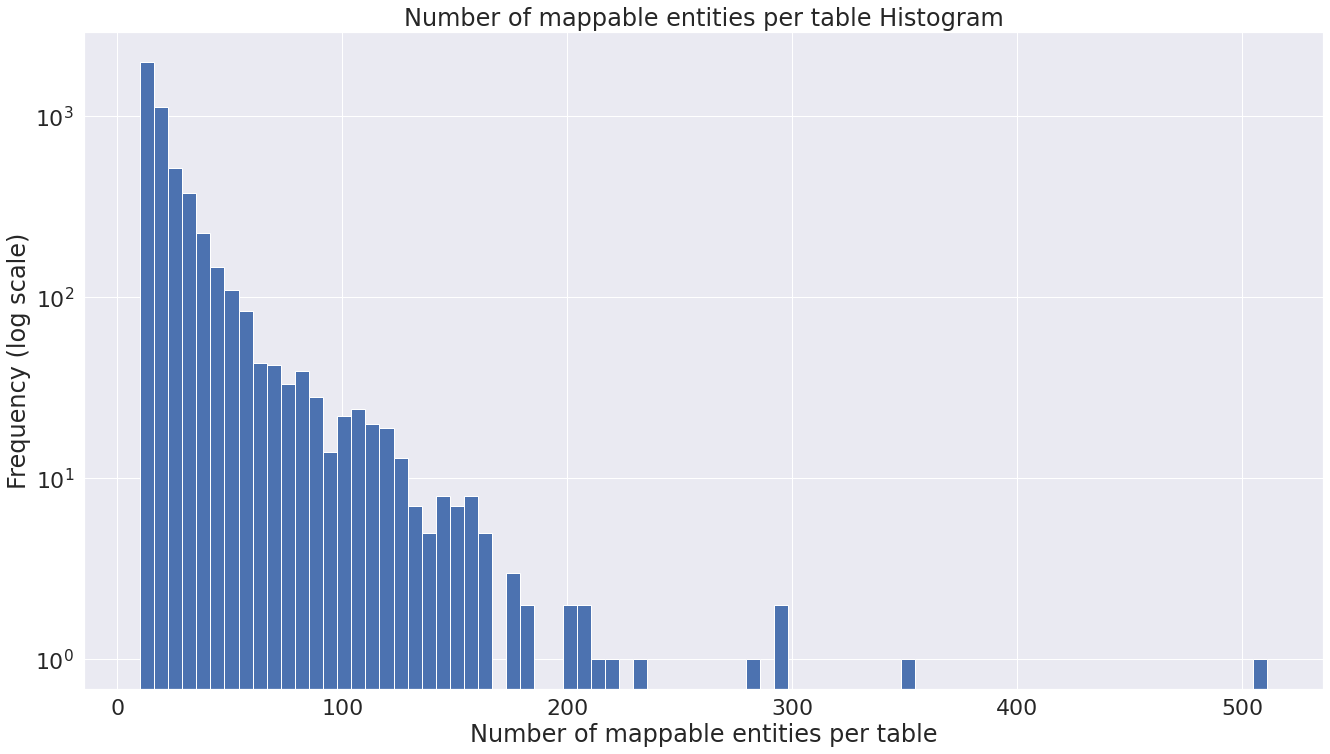

In [8]:
# Number of entities across all candidate tables for queries
num_entities_full = []
for list in df_queries['num_entities']:
    num_entities_full += list
ax = plt.hist(num_entities_full, bins=80)
plt.yscale('log');plt.xlabel("Number of mappable entities per table")
plt.ylabel('Frequency (log scale)');plt.title('Number of mappable entities per table Histogram');plt.tight_layout()
plt.savefig('../figures/num_entities_per_table.svg')

# Extract queries

In [9]:
tableIDToEntities_path = '../../../index/www18_wikitables/tableIDToEntities.ttl'

# Construct dictionary of tableID->list of entities
entities_per_table_dict = get_entities_per_table_dict(tableIDToEntities_path)

8360976it [00:11, 746248.64it/s]


In [10]:
# Dictionary mapping each wikipage to the table_id chosen as for its query
wikipage_to_table_id_dict = {}

# For each wikipage in df_queries generate a query by selecting the entities from the table with the most entities
for _, row in df_queries.iterrows():
    # Find table with larget number of entities and set it as the query table
    max_idx = np.argmax(row['num_entities'])
    selected_table = row['tables'][max_idx]

    wikipage_to_table_id_dict[row['wikipage']] = selected_table

    create_query_file(dir='queries/table_with_most_entities/', filename='wikipage_' + str(row['wikipage_id']), 
        query_entity_tuples=[entities_per_table_dict[selected_table]]
    )

# Evaluate Queries

In [11]:
evaluation_dir = '../../../search/wikipage_tables_analysis/table_with_most_entities/'

## Evaluation Parameters

* **ppr_num_tables**: Number of distinct tables that were scored using PPR
* **num_tables**: The number of valid tables found for the current Wikipage (valid means with mappable entities >= 10)
* **intersection_size**: The number of overlapping tables between the `ppr_num_tables` and `num_tables` lists
* **avg_rank**: The average rank of the tables found in the intersecting set of tables
* **ideal_avg_rank**: `(intersection_size + 1) / 2`
* **coverage**: `intersection_size / num_tables`
* **rank_score**: `ideal_avg_rank / avg_rank`
* **score**: `coverage * rank_score`

In [20]:
# Dictionary used to construct the evaluation dataframe
evaluation_df_dict = {'wikipage': [], 'wikipage_id': [], 'q_table_id': [], 'ppr_num_tables': [],
    'num_tables': [], 'intersection_size': [], 'avg_rank': [], 'coverage': [], 'ideal_avg_rank': [],
    'rank_score': [], 'score': []
}

# Loop over each outfile in the evaluation_dir to construct the evaluation dataframe
wikipage_dirs = sorted(os.listdir(evaluation_dir))
for wikipage_dir in wikipage_dirs:
    scores_file_path = evaluation_dir + wikipage_dir + '/search_output/filenameToScore.json'
    wikipage_id = int(wikipage_dir.split('_')[1])
    
    if Path(scores_file_path).exists():
        # Read the scores json file
        with open(scores_file_path, 'r') as fp:
            ppr_scored_tables = json.load(fp)['scores']
        
        ppr_scored_tables = [table_dict['tableID'] for table_dict in ppr_scored_tables]


        cur_wikipage = df_queries[df_queries['wikipage_id'] == wikipage_id]['wikipage'].values[0]
        gt_tables = df_queries[df_queries['wikipage_id'] == wikipage_id]['tables'].values[0]
        intersection = set(ppr_scored_tables) & set(gt_tables)

        ranks = []
        for table in intersection:
            if table in ppr_scored_tables:
                ranks.append(ppr_scored_tables.index(table) + 1)
        
        avg_rank = np.mean(ranks)
        ideal_avg_rank = (len(intersection) + 1) / 2
        coverage = len(intersection) / len(gt_tables)

        # Update the dictionary
        evaluation_df_dict['wikipage'].append(cur_wikipage)
        evaluation_df_dict['wikipage_id'].append(wikipage_id)
        evaluation_df_dict['q_table_id'].append(wikipage_to_table_id_dict[cur_wikipage])
        evaluation_df_dict['ppr_num_tables'].append(len(ppr_scored_tables))
        evaluation_df_dict['num_tables'].append(len(gt_tables))

        evaluation_df_dict['intersection_size'].append(len(intersection))
        evaluation_df_dict['avg_rank'].append(avg_rank)
        evaluation_df_dict['coverage'].append(coverage)
        evaluation_df_dict['ideal_avg_rank'].append(ideal_avg_rank)
        evaluation_df_dict['rank_score'].append(ideal_avg_rank / avg_rank)
        evaluation_df_dict['score'].append(coverage * (ideal_avg_rank / avg_rank))

evaluation_df = pd.DataFrame.from_dict(evaluation_df_dict)
evaluation_df

,wikipage,wikipage_id,q_table_id,ppr_num_tables,num_tables,intersection_size,avg_rank,coverage,ideal_avg_rank,rank_score,score
0,https://en.wikipedia.org/wiki/List_of_cricket_...,105508,table-0714-566.json,49,21,1,1.000000,0.047619,1.0,1.000000,0.047619
1,https://en.wikipedia.org/wiki/List_of_Yes_conc...,105846,table-0716-418.json,113,22,12,29.750000,0.545455,6.5,0.218487,0.119175
2,https://en.wikipedia.org/wiki/2007_Giro_d'Ital...,106413,table-0720-145.json,235,20,18,29.000000,0.900000,9.5,0.327586,0.294828
3,https://en.wikipedia.org/wiki/2007_Giro_d'Ital...,106482,table-0720-558.json,205,21,9,38.777778,0.428571,5.0,0.128940,0.055260
4,https://en.wikipedia.org/wiki/List_of_European...,108301,table-0733-908.json,199,24,24,17.458333,1.000000,12.5,0.715990,0.715990
...,...,...,...,...,...,...,...,...,...,...,...
199,https://en.wikipedia.org/wiki/2009_NECBL_playoffs,95983,table-0647-20.json,161,32,32,37.156250,1.000000,16.5,0.444071,0.444071
200,https://en.wikipedia.org/wiki/2008_Giro_d'Ital...,96697,table-0652-340.json,227,20,5,65.600000,0.250000,3.0,0.045732,0.011433
201,https://en.wikipedia.org/wiki/2010_Tour_of_Cal...,96903,table-0654-9.json,219,20,8,62.750000,0.400000,4.5,0.071713,0.028685
202,https://en.wikipedia.org/wiki/2008_Giro_d'Ital...,97182,table-0655-998.json,215,20,5,72.600000,0.250000,3.0,0.041322,0.010331


In [21]:
evaluation_df.mean()

ipykernel_launcher:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


wikipage_id          127468.387255
ppr_num_tables          127.696078
num_tables               24.176471
intersection_size         9.196078
avg_rank                 36.314944
coverage                  0.385823
ideal_avg_rank            5.098039
rank_score                0.395540
score                     0.117410
dtype: float64

In [22]:
evaluation_df.std()

ipykernel_launcher:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


wikipage_id          69460.857037
ppr_num_tables          68.735058
num_tables               5.083368
intersection_size        8.543761
avg_rank                33.136917
coverage                 0.338621
ideal_avg_rank           4.271880
rank_score               0.382053
score                    0.183868
dtype: float64